In [190]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
%matplotlib inline

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Good luck!

When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews.

After all, people who eat chocolate might just be happier people.

In [171]:
df = pd.read_csv('/Users/Stephanie/downloads/epi_r.csv')

In [172]:
len(df)

20052

In [173]:
na = df.isna().sum()
na[na > 0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [174]:
df.isna().any(1).sum()

4188

We're gonna drop about 20% of the data. But we still have 15k of rows. If when removing features we find out we dindn't keep any of these, we can just go back to the 20k and drop these nutritional features

In [175]:
nutri_df = df.dropna()

We really have a bunch of features

In [176]:
len(nutri_df.columns)

680

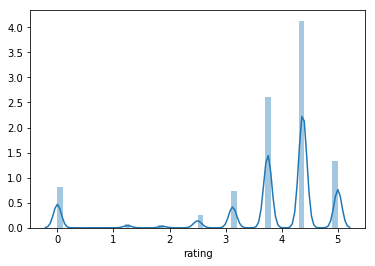

In [177]:
sns.distplot(nutri_df.rating)

In [178]:
# Rating as binary
nutri_df.loc[:, 'rating'] = np.where(nutri_df.rating > 4, 1, 0)

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [179]:
raw_X = nutri_df.drop(['title', 'rating'], 1)
Y = nutri_df.rating

If we look at each column we can realize that a lof of columns have more than 99% of the same response, which means they don't bring much information. we will drop those

In [180]:
responses = raw_X[raw_X == 1].sum()
to_drop = responses[responses/len(raw_X) < .01]
len(to_drop)

474

In [181]:
raw_X.drop(to_drop.index, 1, inplace=True)

In [182]:
thold = .15
vt = VarianceThreshold(threshold=thold)
vt.fit(raw_X)

VarianceThreshold(threshold=0.15)

In [183]:
idx = np.where(vt.variances_ > thold)[0]

In [184]:
final_X = raw_X.iloc[:,idx]

In [186]:
svc = SVC()
svc.fit(final_X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [189]:
svc.score(final_X, Y)

0.656833081190116

In [192]:
cross_val_score(svc, final_X, Y, cv=5)

array([0.57655955, 0.56413489, 0.57138355, 0.57786885, 0.56715006])

In [194]:
Y_ = svc.predict(final_X)
pd.crosstab(Y, Y_,
            rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,3437,3769,7206
1,1675,6983,8658
All,5112,10752,15864
